В цьому домашньому завданні ми проведемо додаткові експерименти для рішення задачі бінарної класифікації і створимо ваш новий submission на змагання на Kaggle.

-----------


**Завдання 0**. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

**Завдання 1**. **Збираємо весь код з попереднього ДЗ в одному місці.** В лекційному ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb` ми познайомились з поняттям пайплайнів, а також я показала, як компактно виглядає рішення МЛ задачі, якщо ми зберемо весь код разом.

Оскільки ми далі будемо робити експерименти, які включають ті самі етапи попередньої обробки, але інше моделювання - буде зручно мати весь код компактно і під рукою. Тому зараз ми займемось збором коду до купи :) Після цього завдання для подальших експериментів ви можете перенести частини розвʼязку взагалі в окремий `.py` файл, аби було зручно імпортувати функції.

Зі свого рішення в попередньому домашньому завданні (`Логістична регресія з scikit learn.ipynb`) зберіть усі кроки розвʼязку задачі разом з використанням `sklearn.Pipeline` за прикладом з лекції.

Ваш код нижче має містити
1. Читання даних з файлу (поза пайплайном).
2. Розбиття на тренувальний і валідаційний набори, де валідаційний містить 20% даних (поза пайплайном).
3. Виділення категоріальних і числових колонок (поза пайплайном).
4. Підготовку категоріальних і числових колонок (частина пайплайну). В прикладі в лекції ми оформлювали обробку числових і категоріальних колонок в окремі трансформери `numeric_transformer`, `categorical_cols`. Рекоемндую зробити саме так, так потім зручніше вносити зміни :)
5. Тренування лог регресії (частина пайплайну).
6. Запуск пайплайну на тренування на трен. даних (поза пайплайном).
7. Запуск пайплайну на передбачення на трен і вал. даних і вимір метрик якості ROC-AUC + вивдення Confusion Matrix (поза пайплайном).
8. Збереження моделі в формат joblib (поза пайплайном).

Ви це все вже зробили в попереднтьому ДЗ! Тож, тут просто заадча все зібрати разом.

Нижче я додала підказки, що покроково ви маєте зробити. Якщо ви почуваєтесь впевнено, можете видалити ці підказки і реалізувати все самостійно, або ж - просто заповнити пропуски.

Завдання оцінюється в 10 балів. Головний результат - аби код в фіналі був робочий. Бо за не робочий нам гроші ніхто не заплатить :)

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import joblib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import PolynomialFeatures



In [6]:
path = "../../../data/"
raw_df = pd.read_csv(path + "train.csv", index_col=0)

Train f1: 0.639559913896197, auc: 0.8825345204817898
Area under ROC score on Train dataset: 0.88%


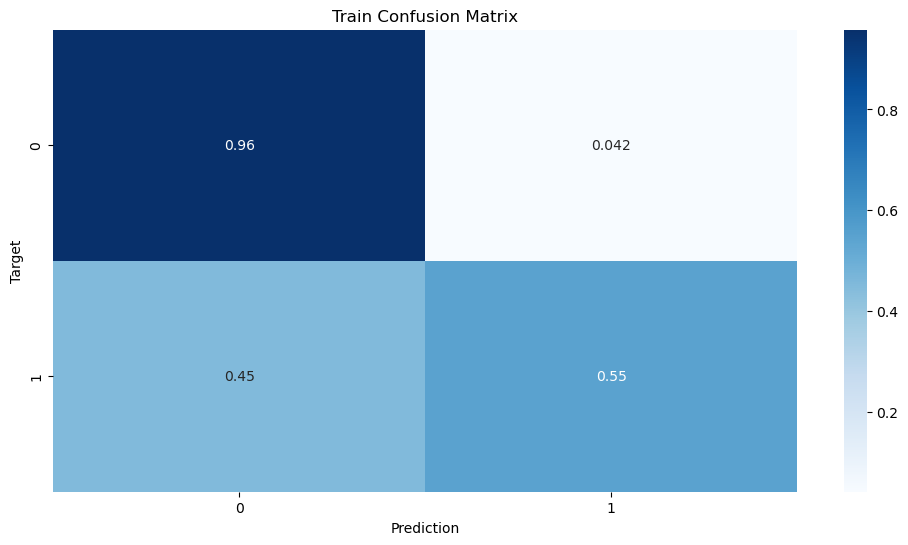

Validation f1: 0.6389658356417359, auc: 0.8796440085053845
Area under ROC score on Validation dataset: 0.88%


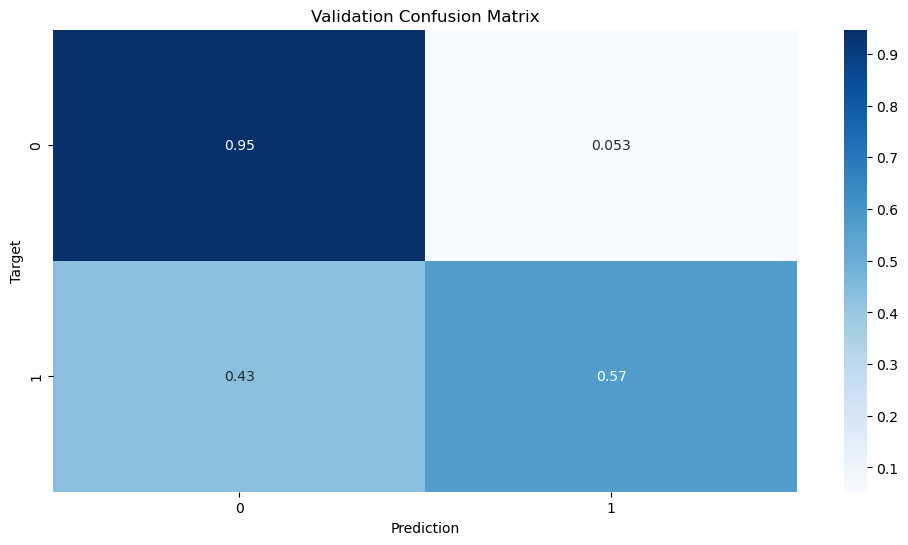

['bank_2.joblib']

In [20]:


# # Створюємо трен. і вал. набори
train_df, val_df = train_test_split(raw_df, test_size=0.2, random_state=42, stratify=raw_df['Exited'])

input_cols = raw_df.drop(columns=['Exited']).columns.tolist()
train_inputs = train_df[input_cols].copy()
val_inputs = val_df[input_cols].copy()

target_col = 'Exited'
train_targets = train_df[target_col].copy()
val_targets = val_df[target_col].copy()

# Виділення категоріальних і числових колонок
numeric_cols = train_df[input_cols].select_dtypes(include=np.number).columns.tolist()
numeric_cols.remove('CustomerId')

categorical_cols = train_df[input_cols].select_dtypes(include='object').columns.tolist()
categorical_cols.remove('Surname')

# # Створюємо трансформери для числових і категоріальних колонок
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[ 
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop = 'if_binary'))
])


# # Комбінуємо трансформери для різних типів колонок в один препроцесор
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
])

# # Стоврюємо пайплайн, який спочатку запускає препроцесинг, потім тренуєм модель
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

model_pipeline.fit(train_inputs, train_targets)


# Функція, щоб передбачати і рахувати метрики
def predict_and_plot(model_pipeline, inputs, targets, name=''):
    # predictions = model.predict(inputs)
    predictions_proba = model_pipeline.predict_proba(inputs)[:, 1]
    preds = (predictions_proba >= 0.5).astype(int)

    f1 = f1_score(targets, preds)
    roc_auc = roc_auc_score(targets, predictions_proba)

    print(f'{name} f1: {f1}, auc: {roc_auc}')

    print(f"Area under ROC score on {name} dataset: {roc_auc:.2f}%")
    confusion_matrix_ = confusion_matrix(targets, preds, normalize='true')
    plt.figure(figsize=(12, 6))
    sns.heatmap(confusion_matrix_, annot=True, cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()
    return preds

# Оцінюємо модель на трен і вал даних
train_preds = predict_and_plot(model_pipeline, train_inputs, train_targets, 'Train')
val_preds = predict_and_plot(model_pipeline, val_inputs, val_targets, 'Validation')

# Зберігаємо модель для подальшого використання
joblib.dump(model_pipeline, 'bank_2.joblib')



In [37]:
# Перевіряємо чи модель виводить такі самі значення як і для попереднього ДЗ без пайплайну 
# Очікувані значення 'Ground: [0.01301626 0.26753732 0.12116485 0.37750233 0.00156514]'
(f'Ground: {model_pipeline.predict_proba(train_inputs)[:,1][:5]}')

'Ground: [0.01301626 0.26753732 0.12116485 0.37750233 0.00156514]'

In [21]:
model_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts', 'HasCrCard',
                                                   'IsActiveMember',
                                                   'EstimatedSalary']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Geography', 'Gender'])])),
                ('classifier', LogisticRegression())])

## Висновок 1
 
- Пайплайн працює коректно. Метрики точності співпадають з результатами без пайплану та ймовірність для перших 5 записів така сама як була без використання пайплайнів.
- Так само ми маємо ідентичні показники f1 та auc з попереднім завданням

**Завдання 2**. Такс, у нас з вами є вже готовий пайплайн. Давайте проведемо нові експерименти.

  Додайте в попередню обробку числових колонок генерацію polinomal features до степені 2 включно. Для цього створіть новий препроцесор і створіть новий пайплайн.

  Запустіть пайплайн на тренування і виведіть метрики для тренувального і валідаційного набору. Напишіть, як вам модель? Чи спостерігається в цій моделі overfit чи underfit? Чи ця модель добре генералізує?

Train f1: 0.736560339058666, auc: 0.9310182036170737
Area under ROC score on Train dataset: 0.93%


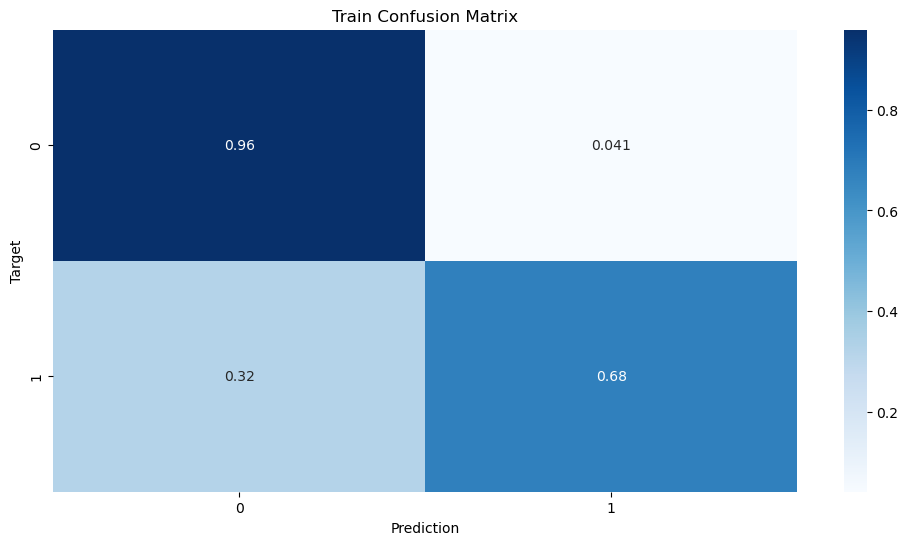

Validation f1: 0.7250437828371279, auc: 0.9284059263323958
Area under ROC score on Validation dataset: 0.93%


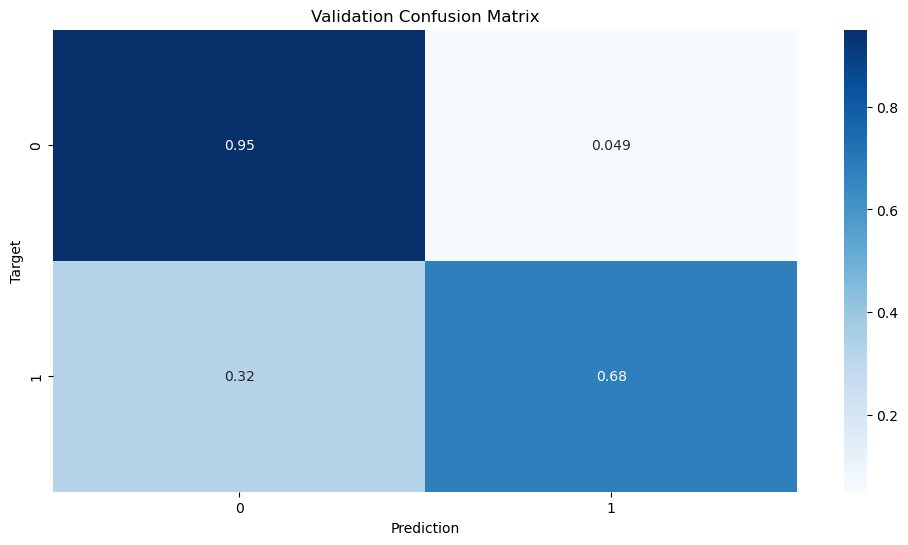

In [22]:
def create_polinom_pipline(degree):
    # # Створюємо трансформери для числових і категоріальних колонок
    numeric_transformer_pol = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('polynom', PolynomialFeatures(degree=degree)),
    ])

    # # Комбінуємо трансформери для різних типів колонок в один препроцесор
    preprocessor_pol = ColumnTransformer(
        transformers = [
            ('num', numeric_transformer_pol, numeric_cols),
            ('cat', categorical_transformer, categorical_cols)
    ])

    # # Стоврюємо пайплайн, який спочатку запускає препроцесинг, потім тренуєм модель
    model_pipeline_pol = Pipeline(steps=[
        ('preprocessor', preprocessor_pol),
        ('classifier', LogisticRegression())
    ])
    
    return model_pipeline_pol

model_pipeline_pol2 = create_polinom_pipline(degree = 2)
model_pipeline_pol2.fit(train_inputs, train_targets)

# Оцінюємо модель на трен і вал даних
train_preds_pol2 = predict_and_plot(model_pipeline_pol2, train_inputs, train_targets, 'Train')
val_preds_pol2 = predict_and_plot(model_pipeline_pol2, val_inputs, val_targets, 'Validation')

In [23]:
model_pipeline_pol2.named_steps['preprocessor'].get_feature_names_out()

array(['num__1', 'num__CreditScore', 'num__Age', 'num__Tenure',
       'num__Balance', 'num__NumOfProducts', 'num__HasCrCard',
       'num__IsActiveMember', 'num__EstimatedSalary',
       'num__CreditScore^2', 'num__CreditScore Age',
       'num__CreditScore Tenure', 'num__CreditScore Balance',
       'num__CreditScore NumOfProducts', 'num__CreditScore HasCrCard',
       'num__CreditScore IsActiveMember',
       'num__CreditScore EstimatedSalary', 'num__Age^2',
       'num__Age Tenure', 'num__Age Balance', 'num__Age NumOfProducts',
       'num__Age HasCrCard', 'num__Age IsActiveMember',
       'num__Age EstimatedSalary', 'num__Tenure^2', 'num__Tenure Balance',
       'num__Tenure NumOfProducts', 'num__Tenure HasCrCard',
       'num__Tenure IsActiveMember', 'num__Tenure EstimatedSalary',
       'num__Balance^2', 'num__Balance NumOfProducts',
       'num__Balance HasCrCard', 'num__Balance IsActiveMember',
       'num__Balance EstimatedSalary', 'num__NumOfProducts^2',
       'num__NumOfPr

## Висновок 2
`Напишіть, як вам модель? Чи спостерігається в цій моделі overfit чи underfit? Чи ця модель добре генералізує?`

|model|train f1|train auc| val f1|val auc| 
|-----|--------|---------|-------|-------|
|original|0.6395|0.8796| 0.6389|0.8825| 
|pol2    |0.7365|0.9310| 0.7250|0.9284|

- Модель виглядає чудово, При додаванні полінома 2-го ступеня всі показники підвишилися. Генералізація стала значно кращою, але не ідеальна.
- Також модель значно краще стала прогнозувати клас 1 (TN виріс майже до 70% по confusion matrix)
- Точності тренувальної та валідаційної вибірок виросли однаково пропорційно. Ніякого overfit чи underfit не спостерігається


**Завдання 3**. Тепер давайте створимо ще новий пайплайн, тільки тепер поліноміальні ознаки згенеруємо до степені 4. Зробіть висновок про якість моделі. Якщо вам подобається резульат якоїсь з моделей в цьому ДЗ - рекомендую зробити submission в змаганні.

Train f1: 0.7542147293700089, auc: 0.9451640906443166
Area under ROC score on Train dataset: 0.95%


c:\Users\Olha Shaposhnyk\anaconda3\envs\ml_course\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


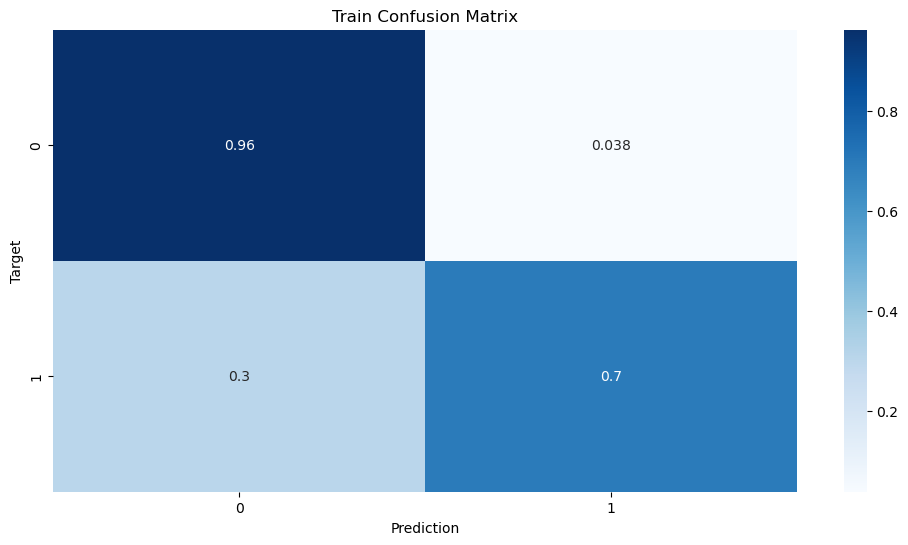

Validation f1: 0.7134092900964066, auc: 0.9234145003086631
Area under ROC score on Validation dataset: 0.92%


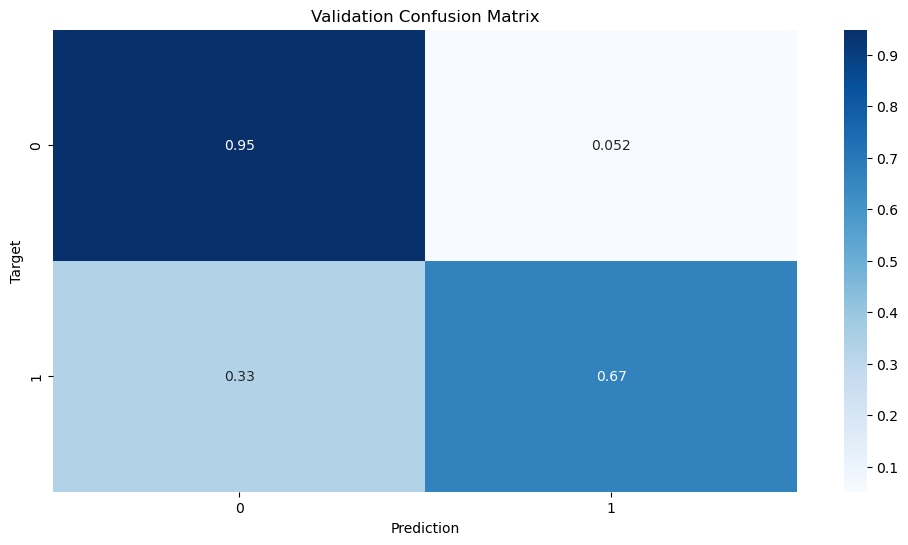

In [24]:
model_pipeline_pol4 = create_polinom_pipline(degree = 4)
model_pipeline_pol4.fit(train_inputs, train_targets)

# Оцінюємо модель на трен і вал даних
train_preds_pol4 = predict_and_plot(model_pipeline_pol4, train_inputs, train_targets, 'Train')
val_preds_pol4 = predict_and_plot(model_pipeline_pol4, val_inputs, val_targets, 'Validation')

## Висновок 3


- Поліном 4 степеня: метрики тренувального набору даних виросли, але метрики на валідації всі впали (стали нижчі ніж навіть при поліномі 2). Наша модель - overfit. 4 степінь занадто високий для цих даних
- Натренуємо нижче також ще один варіант з поліномом степеня 3 для більш повного аналізу(аби можна було проаналізувати послідовність 2,3,4)
- Тому повернемося на крок назад і зробимо поліном 3 степеня. він трохи краще генералізує, ніж поліном 2-го ступеня, але при цьому ми позбавилися проблеми перенавчання що притаманні 4-му степеню. ТОчність зростає на обох вибірках.
- засабмітемо всі три моделі аби провести додаткові висновки про генералізацію моделей

|model|train f1|train auc| val f1|val auc| kaggle score|
|-----|--------|---------|-------|-------|------------|
|original|0.6395|0.8796| 0.6389|0.8825| 0.88680 |
|pol2    |0.7365|0.9310| 0.7250|0.9284| 0.93308 |
|pol3    |0.7453|0.9381| **0.7299**|**0.9333**|**0.93495** |
|pol4    |**0.7542**|**0.9451**| 0.7134|0.9234|0.92846|

- Очікувано на kaggle набір з поліноміномом 3 показав найкраший результат. Але різниця між поліномом 2 та 3 ступеня дуже незначна. Я не впевнена чи для реальної задачі варто ускладнювати обробку даних та робити висновки менш інтерпретованими (з використанням полінома 3 ступеня). Я б зупинила свій вибір на поліномі 2-го ступені 
- Цікаво що для kaggle бал завжди вищий ніж валідаційний (інколи навіть і за тренувальний скор). Це може свідчити про трохи інший розподіл даних на змаганні. 

Train f1: 0.7453693372015175, auc: 0.9381510855145507
Area under ROC score on Train dataset: 0.94%


c:\Users\Olha Shaposhnyk\anaconda3\envs\ml_course\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


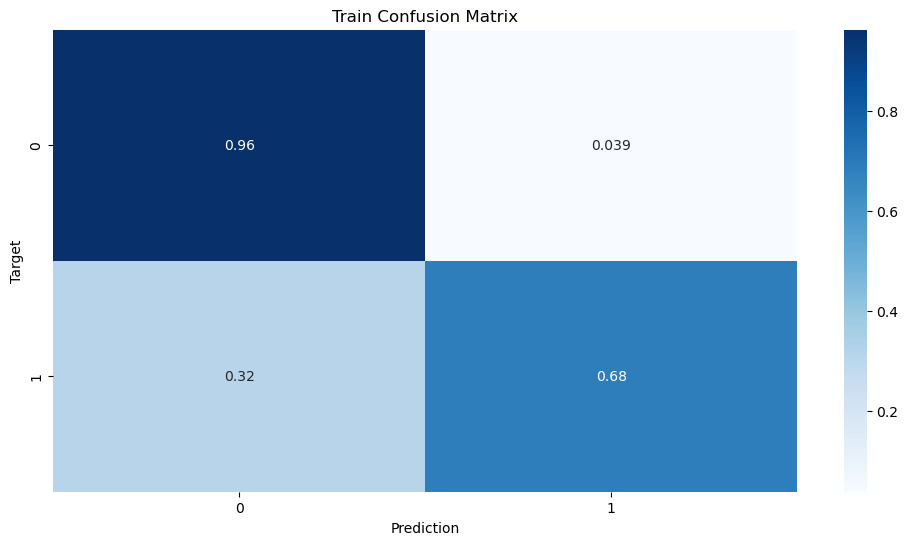

Validation f1: 0.7299912049252418, auc: 0.9333630564510598
Area under ROC score on Validation dataset: 0.93%


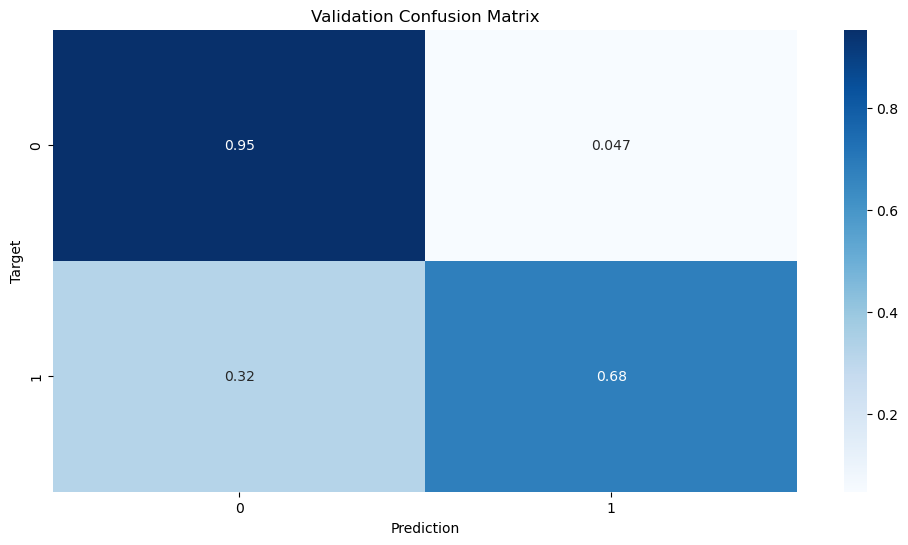

In [25]:
model_pipeline_pol3 = create_polinom_pipline(3)
model_pipeline_pol3.fit(train_inputs, train_targets)

# Оцінюємо модель на трен і вал даних
train_preds_pol4 = predict_and_plot(model_pipeline_pol3, train_inputs, train_targets, 'Train')
val_preds_pol4 = predict_and_plot(model_pipeline_pol3, val_inputs, val_targets, 'Validation')

In [26]:
test_raw_df = pd.read_csv(path + 'test.csv')
test_pol2 = test_raw_df.copy()
preds_2 = model_pipeline_pol2.predict_proba(test_raw_df)[:,1]
test_pol2['Exited'] = preds_2


test_pol4 = test_raw_df.copy()
preds_4 = model_pipeline_pol4.predict_proba(test_raw_df)[:,1]
test_pol4['Exited'] = preds_4

submit_pol2 = pd.read_csv(path + 'sample_submission.csv')
submit_pol4 = submit_pol2.copy()
submit_pol2['Exited'] = test_pol2['Exited']
submit_pol4['Exited'] = test_pol4['Exited']


# submit_pol2.to_csv(path + 'submission_log_pol2.csv', index=False)
# submit_pol4.to_csv(path + 'submission_log_pol4_minmax.csv', index=False)

**Завдання 4. Перенавчання і регуляризація**.

  Скачайте набір даних `regression_data.csv`. Звичайте набір даних з `regression_data.csv`, розбийте на train і test (в тест 20%) і натренуйте модель лінійної регресії з масштабуванням числових ознак і поліноміальними ознаками до степені **5 включно**.

  Виміряйте якість прогностичної моделі і зробіть висновок, чи модель хороша, чи вона добре генералізує?


In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

In [19]:
def create_poly_regress_pipline(degree, cols_list, model = LinearRegression()):
    numeric_transformer = Pipeline(steps=[
        ('polynom', PolynomialFeatures(degree=degree)),
        ('scaler', StandardScaler())
    ])

    # # Комбінуємо трансформери для різних типів колонок в один препроцесор
    preprocessor = ColumnTransformer(
        transformers = [
            ('num', numeric_transformer, cols_list)
    ])

    model_pipeline_regress = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    return model_pipeline_regress

In [20]:
df_regress = pd.read_csv(path + 'regression_data.csv')
df_regress.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,target
0,-0.190339,-1.382800,-0.875618,0.538910,-1.037246,28.938854
1,-0.321386,-0.563725,0.412931,-0.147057,-0.825497,-7.664581
2,2.122156,-1.519370,1.032465,-1.260884,0.917862,-63.845482
3,-1.380101,-0.055548,-1.703382,0.074095,1.628616,4.076259
4,-0.072829,-1.514847,-0.846794,0.714000,0.473238,34.879013


In [21]:
X_train_regress, X_val_regress, y_train_regress, y_val_regress = train_test_split(df_regress.drop(columns=['target']), df_regress['target'], test_size=0.2, random_state=42)

model_pipeline_regress_5 = create_poly_regress_pipline(5, X_train_regress.columns.tolist(), LinearRegression())
model_pipeline_regress_5.fit(X_train_regress, y_train_regress)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('polynom',
                                                                   PolynomialFeatures(degree=5)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['feature_1', 'feature_2',
                                                   'feature_3', 'feature_4',
                                                   'feature_5'])])),
                ('classifier', LinearRegression())])

In [22]:
y_pred_train = model_pipeline_regress_5.predict(X_train_regress)
y_pred_test =  model_pipeline_regress_5.predict(X_val_regress)

In [23]:
df_regress.target.mean(), df_regress.target.std()

(-3.9029835552255245, 45.46662135515645)

In [24]:
rmse_train = root_mean_squared_error(y_train_regress, y_pred_train)
print(f'RMSE train: {rmse_train}')
rmse_val = root_mean_squared_error(y_val_regress, y_pred_test)
print(f'RMSE validation: {rmse_val}')


RMSE train: 1.4550170951608336e-13
RMSE validation: 12.38186114275268


## Висновок 4
` Виміряйте якість прогностичної моделі і зробіть висновок, чи модель хороша, чи вона добре генералізує?`

- RMSE train: 1.455e-13 = 0.0000000000001455
- RMSE validation: 12.382

- Різниця між тренуванням та валідацією відрізняється на 14 порядків. Це виглядає як дуже погана модель.
- Така модель майже ніколи не помиляється на тренування, але робить значну помилку на валідації . Хоча за умови що середнє = -3.9 та std = 45.5, то помилка в 12 не здається дуже великою.Але модель всеодно погана через великий розрив між показниками між вибірками.

**Завдання 5**. Натренуйте моделі Lasso(), Ridge(), ElasaticNet() на цих даних (з поліном ознаками до степені 20 включно), порівняйте якість з тою, яка була отримана з лінійною регресією. Яка модель найкраще генералізує і чому на ваш погляд (можливо треба буде для відповіді зробити додатковий аналіз ознак)?

In [25]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet

In [26]:
models = {LinearRegression(),
    Ridge(),
    Lasso(),
    ElasticNet()}

coef = pd.DataFrame(columns=['feature_name'])

for model in models:
    model_pipeline_regress_20 = create_poly_regress_pipline(20, X_train_regress.columns.tolist(),model)
    model_pipeline_regress_20.fit(X_train_regress, y_train_regress)

    coef.feature_name = model_pipeline_regress_20.named_steps['preprocessor'].get_feature_names_out()
    coef[str(model)] = model_pipeline_regress_20.named_steps['classifier'].coef_.round(5).flatten()

    y_train20 = model_pipeline_regress_20.predict(X_train_regress)
    y_val20 = model_pipeline_regress_20.predict(X_val_regress)
    rmse_train20 = root_mean_squared_error(y_train_regress, y_train20)
    rmse_val20 = root_mean_squared_error(y_val_regress, y_val20)
    print(f'RMSE train {model}: {rmse_train20:.4}, RMSE val {model}: {rmse_val20:.4}') 
    

RMSE train Ridge(): 1.054, RMSE val Ridge(): 27.8
RMSE train ElasticNet(): 12.04, RMSE val ElasticNet(): 20.62
RMSE train Lasso(): 1.479, RMSE val Lasso(): 1.392
RMSE train LinearRegression(): 3.502e-12, RMSE val LinearRegression(): 65.39


In [27]:
((coef.iloc[:, 1:]) != 0).sum()

Ridge()               53017
ElasticNet()            130
Lasso()                   1
LinearRegression()    53047
dtype: int64

In [28]:
coef.sort_values(by = ['Lasso()'], ascending=False).head(10)

,feature_name,Ridge(),ElasticNet(),Lasso(),LinearRegression()
4,num__feature_4,29.78112,15.04759,43.12075,35.40057
0,num__1,0.00000,0.00000,0.00000,0.00000
35424,num__feature_1^7 feature_3^3 feature_4^8 featu...,0.00118,0.00000,-0.00000,-0.00022
35414,num__feature_1^7 feature_3^4 feature_4^8,-0.00016,0.00000,-0.00000,0.00028
35415,num__feature_1^7 feature_3^4 feature_4^7 featu...,-0.00172,-0.00000,0.00000,0.00024
35416,num__feature_1^7 feature_3^4 feature_4^6 featu...,0.00059,0.00000,-0.00000,0.00053
35417,num__feature_1^7 feature_3^4 feature_4^5 featu...,-0.00159,-0.00000,0.00000,0.00066
35418,num__feature_1^7 feature_3^4 feature_4^4 featu...,0.00104,0.00000,-0.00000,-0.00080
35419,num__feature_1^7 feature_3^4 feature_4^3 featu...,-0.00332,-0.00000,0.00000,0.00241
35420,num__feature_1^7 feature_3^4 feature_4^2 featu...,0.00142,-0.00000,-0.00000,-0.00083


## Висновок 5

`Яка модель найкраще генералізує і чому на ваш погляд (можливо треба буде для відповіді зробити додатковий аналіз ознак)`

|model|train|val| # ненульових фіч|
|-----|------|----|-----|
|ElasticNet      |12.04    |20.62|130|
|Lasso           |1.479    |1.392|1|
|Ridge           |1.054   |27.8 |53017|
|LinearRegression|3.502e-12|65.39|53047|

- Найкраще себе проявила Lasso регресія з прекрасно низьким показником помилки як і на тренуванні так і на валідації
- Якщо подивитися уважніше на коефіцієнти фіч, то можна побачити що Lasso обнулило майже всі фічі і ми маємо лише одну ненульову фічу (num__feature_4). Бо цей тип штрафу може обнулювати ваги коефіцієнтів.
- Також можна помітити що ця фіча (num__feature_4) має найвищий коефіцієнт для всіх типів регресій, що може свідчити про її сильну важливість. Але всі інші регресій також мають невеликі ненульові коеф. для інших фіч, що може впливати на перенавчання моделей.

  